In [50]:
import torch
import torch.nn as nn
import copy

import torchmetrics

from conplex_dti.model.architectures import SimpleCoembeddingNoSigmoid

from conplex_dti.dataset.datamodules import DTIDataModule
from conplex_dti.featurizer import get_featurizer


In [51]:
# TODO: want to try learning / training on three different models

# 1. TransferCoembedding model with two unfrozen layers
# 2. original model with only RELU layer unfrozen
# 3. original model with lower learning rate


# TODO: eventually do do weights and biases logging
# TODO: eventually do logg instead of print statements
# TODO: eventually add timing

In [52]:
DEVICE = torch.device("cpu")
BATCH_SIZE = 32

In [53]:
# recreate lines 309 -> ~322 from train.py

# load the featurizers 
drug_featurizer = get_featurizer("MorganFeaturizer")
# load from pre-trained prot-bert model
target_featurizer = get_featurizer("ProtBertFeaturizer")


# load data into a drug-target interaction datamodule (combo of dataset/dataloader)
datamodule = DTIDataModule(data_dir = "./new_data/", drug_featurizer=drug_featurizer, target_featurizer=target_featurizer, batch_size=BATCH_SIZE)
datamodule.prepare_data()
datamodule.setup()

# from the datamodules, get dataloaders to use for training, testing, and validation
training_generator = datamodule.train_dataloader()
validation_generator = datamodule.val_dataloader()
testing_generator = datamodule.test_dataloader()

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Drug and target featurizers already exist
ProtBert: 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]


In [54]:
# load previous model from state dict!
model = SimpleCoembeddingNoSigmoid(2048, 1024, 1024)  # TODO: drug_featurizer.shape, target_featurizer.shape 2048, 1024, 1024
model.load_state_dict(torch.load("../pre_trained_model/models/ConPLex_v1_BindingDB.pt", map_location="cpu"))

<All keys matched successfully>

In [55]:
for i, param in enumerate(model.parameters()):
    if i == 0 or i == 2:
        param.requires_grad = False
    elif i == 1 or i == 3:
        param.requires_grad = True

    print(param)

Parameter containing:
tensor([[ 0.0047, -0.0079,  0.0238,  ...,  0.0111,  0.0210,  0.0207],
        [ 0.0153,  0.0114, -0.0300,  ...,  0.0068, -0.0462, -0.0392],
        [ 0.0016,  0.0115, -0.0180,  ..., -0.0070, -0.0049, -0.0085],
        ...,
        [ 0.0366, -0.0195,  0.0033,  ...,  0.0002, -0.0111, -0.0228],
        [ 0.0404,  0.0027,  0.0098,  ..., -0.0241, -0.0017, -0.0129],
        [-0.0063,  0.0096, -0.0328,  ...,  0.0028,  0.0066, -0.0292]])
Parameter containing:
tensor([-0.0171, -0.0019, -0.0151,  ..., -0.0408, -0.0276, -0.0064],
       requires_grad=True)
Parameter containing:
tensor([[-0.0145, -0.0040,  0.0165,  ...,  0.0232,  0.0239, -0.0087],
        [ 0.0004,  0.0061, -0.0367,  ..., -0.0063, -0.0146, -0.0555],
        [-0.0189, -0.0549,  0.0328,  ..., -0.0027, -0.0060,  0.0128],
        ...,
        [ 0.0331, -0.0179, -0.0203,  ...,  0.0261, -0.0122, -0.0455],
        [ 0.0083, -0.0030,  0.0434,  ...,  0.0112,  0.0150, -0.0119],
        [-0.0156,  0.0300,  0.0187,  ...,

In [56]:
model
model = model.to(DEVICE)

In [57]:
# optimizer:
LEARNING_RATE = 0.005 # not same as sam, larger
RESET_AFTER_EPOCHS = 10 # aka lr_t0 from config file TODO: play with this, currently same as sam

opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE) # AdamW is Adam with weight decay
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=RESET_AFTER_EPOCHS)



# More variables
NUM_EPOCHS = 40 # TODO: play with this
VALIDATE_AFTER_EPOCHS = 1 # TODO: play with this
CLASSIFY = True # 309
WATCH_METRIC = "val/aupr" # 310


SAVE_DIRECTORY = "./saved_models/" # TODO: eventually change this
RUN_ID = "test_run" # TODO: eventually change this
from pathlib import Path

In [58]:
# keep track of best model:
max_metric = 0
model_max = copy.deepcopy(model) # currently last (2) layers are random


In [59]:
# line 413 -> 423, NOT doing contrastive learning

# Using Binary Cross Entropy loss function because we are trying to predict a binary label (binding or no binding):
loss_fct = torch.nn.BCELoss() 

# Keep track of how well the model is doing (on each epoch)
val_metrics = {"val/aupr": torchmetrics.AveragePrecision, "val/auroc": torchmetrics.AUROC}
test_metrics = {"test/aupr": torchmetrics.AveragePrecision, "test/auroc": torchmetrics.AUROC}


In [60]:
# FUNCTIONS FOR TRAINING:
import numpy as np
from torch.autograd import Variable

def step(model, batch, device=None):
    if device is None:
        device = torch.device("cpu")

    drug, target, label = batch  # target is (D + N_pool)
    pred = model(drug.to(device), target.to(device))
    label = Variable(torch.from_numpy(np.array(label)).float()).to(device)
    return pred, label



In [61]:
# FUNCTIONS FOR TESTING:
def test(model, data_generator, metrics, device=None, classify=True):
    if device is None:
        device = torch.device("cpu")

    metric_dict = {}

    for k, met_class in metrics.items():
        if classify:
            met_instance = met_class(task="binary")
        else:
            met_instance = met_class()
        met_instance.to(device)
        met_instance.reset()
        metric_dict[k] = met_instance

    model.eval()

    for i, batch in enumerate(data_generator):
        pred, label = step(model, batch, device)
        if classify:
            label = label.int()
        else:
            label = label.float()

        for _, met_instance in metric_dict.items():
            met_instance(pred, label)

    results = {}
    for k, met_instance in metric_dict.items():
        res = met_instance.compute()
        results[k] = res

    for met_instance in metric_dict.values():
        met_instance.to("cpu")

    return results


In [62]:
train_losses = []
val_losses = []

In [63]:

print(f"Beginning Training")

torch.backends.cudnn.benchmark = True

for epo in range(NUM_EPOCHS): # TODO: eventually do tqdm (progress bar)

    print(f"Trainign epoch is {epo + 1}")

    # Training
    model.train()
    for i, batch in enumerate(training_generator):
        # print(f"batch number {i + 1}")
        pred, label = step(model, batch, DEVICE)  # batch is (2048, 1024, 1)
        loss = loss_fct(pred, label)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        # break
    lr_scheduler.step()
    print(f"loss was {loss.cpu().detach().numpy():8f}. Updating learning rate to {lr_scheduler.get_lr()[0]:8f}")
    train_losses.append(loss.cpu().detach().numpy())


    # Validation
    if epo % VALIDATE_AFTER_EPOCHS == 0:
        with torch.set_grad_enabled(False):
            val_results = test(
                model = model,
                data_generator = validation_generator,
                metrics = val_metrics,
                device = DEVICE,
                classify = CLASSIFY,
            )
            val_results["epoch"] = epo 
            
            val_losses.append(val_results[WATCH_METRIC])

            if val_results[WATCH_METRIC] > max_metric:
                print(f"Validation AUPR {val_results[WATCH_METRIC]:8f} > previous max {max_metric:8f}")
                model_max = copy.deepcopy(model)
                max_metric = val_results[WATCH_METRIC]
                model_save_path = Path(
                    f"{SAVE_DIRECTORY}/{RUN_ID}_best_model_epoch{epo:02}.pt"
                )
                torch.save(
                    model_max.state_dict(),
                    model_save_path,
                )
                print(f"Saving checkpoint model to {model_save_path}")
                
            print(f"Validation at Epoch {epo + 1}")
            for k, v in val_results.items():
                if not k.startswith("_") and not k.startswith("epoch"):
                    print(f"{k}: {v}")


Beginning Training
Trainign epoch is 1
loss was 1.007005. Updating learning rate to 0.004878
Validation AUPR 0.507561 > previous max 0.000000
Saving checkpoint model to saved_models/test_run_best_model_epoch00.pt
Validation at Epoch 1
val/aupr: 0.5075610280036926
val/auroc: 0.5103702545166016
Trainign epoch is 2
loss was 0.790159. Updating learning rate to 0.004523
Validation at Epoch 2
val/aupr: 0.5058331489562988
val/auroc: 0.5121147632598877
Trainign epoch is 3
loss was 1.176809. Updating learning rate to 0.003969
Validation AUPR 0.507932 > previous max 0.507561
Saving checkpoint model to saved_models/test_run_best_model_epoch02.pt
Validation at Epoch 3
val/aupr: 0.5079318284988403
val/auroc: 0.5097887516021729
Trainign epoch is 4
loss was 0.796270. Updating learning rate to 0.003273
Validation at Epoch 4
val/aupr: 0.5074411630630493
val/auroc: 0.5159914493560791
Trainign epoch is 5
loss was 0.480834. Updating learning rate to 0.002500
Validation AUPR 0.508669 > previous max 0.50793

In [64]:
# Testing
print("Beginning testing")
try:
    with torch.set_grad_enabled(False):
        model_max = model_max.eval()

        test_results = test(
            model = model_max,
            data_generator = testing_generator,
            metrics = test_metrics,
            device = DEVICE,
            classify = CLASSIFY,
        )
        
        test_results["epoch"] = epo + 1

        print("Final Testing")
        for k, v in test_results.items():
            if not k.startswith("_") and not k.startswith("epoch"):
                print(f"{k}: {v}")

        model_save_path = Path(f"{SAVE_DIRECTORY}/{RUN_ID}_best_model.pt")
        torch.save(
            model_max.state_dict(),
            model_save_path,
        )
        print(f"Saving final model to {model_save_path}")

except Exception as e:
    print(f"Testing failed with exception {e}")

Beginning testing
Final Testing
test/aupr: 0.5127537250518799
test/auroc: 0.5578109622001648
Saving final model to saved_models/test_run_best_model.pt


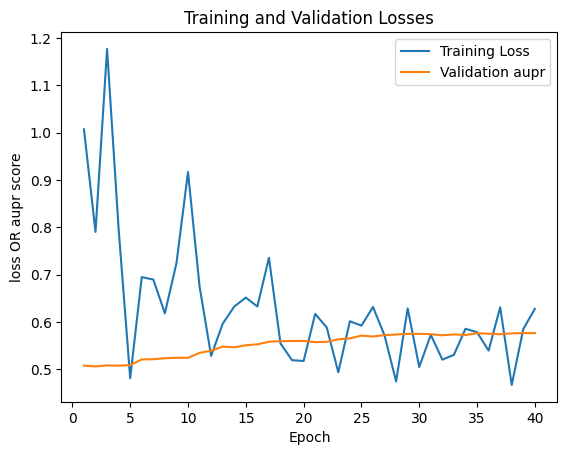

In [65]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(train_losses, val_losses):
    epochs = range(1, NUM_EPOCHS + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation aupr')
    plt.xlabel('Epoch')
    plt.ylabel('loss OR aupr score')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

plot_results(train_losses, val_losses)
